# Centre of a satellite orbit

This code seeks to determine the centre of a satellite orbit
## Background
Satellite state vectors define the position and velocity vectors of a satellite, usually in an Earth-Centred Earth-Fixed (ECEF) coordinate system. Examination of state vectors (for instance those that accompany SAR data, or data that is captured and recorded for Sentinel-1 at https://https://qc.sentinel1.eo.esa.int/aux_poeorb/. Upon examination of the state vector position data (perhaps by looking at 5 sequential state vectors), one finds that the magnitude of the position vector changes showing that with reference the centre of the Earth. The orbit is not locally circular.

SAR processing algorithms that are derived under the assumption of a locally circular orbit would thus not make sense because the effective velocity term used in the development of SAR processing algorithms would not have a sensible basis.

In [1]:
import numpy as np
import numpy.matlib as npmat
from scipy.linalg import expm
from scipy.optimize import minimize
import sys
import datetime
sys.path.append('/home/ishuwa_tinda/local/src/Python/radar')
import matplotlib.pyplot as plt
from measurement.measurement import state_vector_ESAEOD
from measurement.measurement import state_vector
from measurement.arclength import slow
%matplotlib notebook

## Create a state vector object

In [2]:
orbit_file = "/home/ishuwa/local/src/Python/sarsim/radar/orbit/S1B_OPER_AUX_POEORB_OPOD_20180825T110641_V20180804T225942_20180806T005942.EOF"
sv = state_vector_ESAEOD()
start_date = datetime.datetime(2018,8,5,16,0,2)
end_date = datetime.datetime(2018,8,5,16,1,2)
svecs = sv.readStateVectors(orbit_file, start_date, end_date)

## Extract state vector data
The state vector contains both position and velocity components. We're only interested, at the moment, in the position elements

In [3]:
#%% Compute state vectors
s_idx = int(len(sv.measurementTime)/2)
s_time = sv.measurementTime[s_idx]
s_vect = sv.measurementData[s_idx]

# Create a new state vector object to propagate
myrd = state_vector()
myrd.add(s_time, s_vect)

# def satellitePositionsArclength(myrd, prf = 10.0, nSamples=80):
nSamples = 80
prf = 2

deltaT = 1.0/prf

xState = myrd.expandedState(myrd.measurementData[0], 0.0)
# reference_time = myrd.measurementTime[0]
reference_time = np.datetime64(datetime.datetime.strftime(myrd.measurementTime[0], "%Y-%m-%dT%H:%M:%S.%f"))

np_prf = np.timedelta64(int(np.round(1e9/prf)),'ns')
svTime = myrd.measurementTime[0]# + np_prf*rnSamples/2.0
print("Reference time:")
print(reference_time)
print(xState)

Reference time:
2018-08-05T16:00:32.000000
[[ 5.81801992e+06  3.63838253e+06 -1.73832311e+06]
 [ 2.38887416e+03 -3.95033065e+02  7.19726965e+03]
 [-6.57056433e+00 -4.42146174e+00  1.96030175e+00]
 [-3.35991092e-03  1.37494746e-03 -8.10400963e-03]]


In [4]:
myrd.measurementTime

[datetime.datetime(2018, 8, 5, 16, 0, 32)]

In [5]:
# Compute the integration times
half_time = deltaT*nSamples/2
integration_times = np.arange(-half_time, half_time, deltaT)
numerical_sv = myrd.estimateTimeRange(myrd.measurementTime, integrationTimes=integration_times)

In [12]:
npos = numerical_sv[:,0:3].T
nvel = numerical_sv[:,3:6].T

In [7]:
# Create a slow time object
C = slow([reference_time])
C.t = integration_times
dummy = C.diffG(xState)

kappa: 1.414877833e-07 tau: -1.801499892e-08 dkappa: 3.129416920e-17


In [8]:
# Convert time to arclength in the slow-time object
C.t2s()

<IPython.core.display.Javascript object>


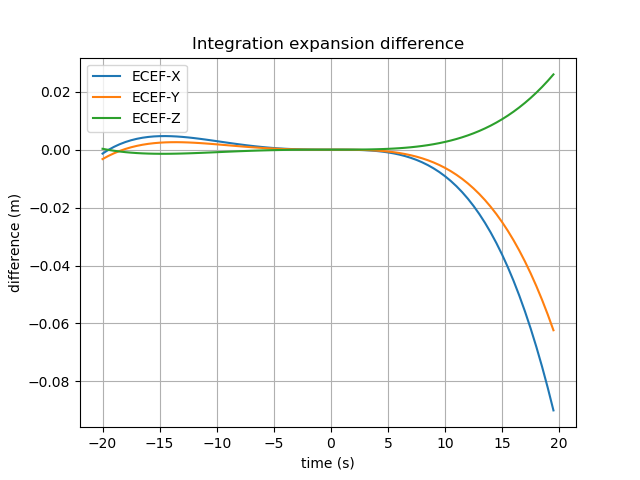

In [9]:
# Plot the differences
plt.figure()
plt.plot(integration_times, (C.c - npos).T)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('difference (m)')
plt.legend(['ECEF-X','ECEF-Y','ECEF-Z'])
plt.title('Integration expansion difference')
plt.show()

In [10]:
# Print the differences
# for sidx in range(len(integration_times)):
#     print(C.s[sidx])
#     print(C.c[:,sidx])
#     print(npos[:,sidx])

In [11]:
0.031/8

0.003875